Dữ liệu IBM Transactions for Anti-Money Laundering bao gồm các giao dịch tài chính được mô phỏng với các đặc điểm sau:

	•	Timestamp: Thời gian thực hiện giao dịch.
	•	From Bank: Tên ngân hàng gửi tiền.
	•	Account: Số tài khoản gửi tiền.
	•	To Bank: Tên ngân hàng nhận tiền.
	•	Account.1: Số tài khoản nhận tiền.
	•	Amount Received: Số tiền mà người nhận nhận được.
	•	Receiving Currency: Loại tiền tệ được sử dụng để nhận.
	•	Amount Paid: Số tiền được gửi đi từ phía người gửi.
	•	Payment Currency: Loại tiền tệ được sử dụng để gửi.
	•	Payment Format: Phương thức thanh toán (ví dụ: chuyển khoản, tiền mặt).

Tập dữ liệu này tập trung vào phân tích các giao dịch giữa các ngân hàng, bao gồm cả thông tin về số tiền, tài khoản, loại tiền tệ và thời gian giao dịch. Nó được thiết kế để hỗ trợ nghiên cứu về phát hiện rủi ro rửa tiền bằng cách sử dụng các kỹ thuật học máy và thống kê.

In [28]:
import os

import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np
from numpy import concatenate
from math import sqrt

import matplotlib.pyplot as plt
import plotly.express as px
import plotly
import seaborn as sns
from collections import Counter

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from category_encoders import CountEncoder, TargetEncoder
from scipy.sparse import hstack

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
df = pd.read_csv("/kaggle/input/ibm-transactions-for-anti-money-laundering-aml/HI-Small_Trans.csv")

In [3]:
print("Các feature của dữ liệu")
print(df.columns);
print("--------------------------------------------------------------------------------------------------------------------")

print("Shape của dữ liệu")
print(df.shape)
print("--------------------------------------------------------------------------------------------------------------------")

df.head()

Các feature của dữ liệu
Index(['Timestamp', 'From Bank', 'Account', 'To Bank', 'Account.1',
       'Amount Received', 'Receiving Currency', 'Amount Paid',
       'Payment Currency', 'Payment Format', 'Is Laundering'],
      dtype='object')
--------------------------------------------------------------------------------------------------------------------
Shape của dữ liệu
(5078345, 11)
--------------------------------------------------------------------------------------------------------------------


,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/01 00:20,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0
1,2022/09/01 00:20,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0
2,2022/09/01 00:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0
3,2022/09/01 00:02,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0
4,2022/09/01 00:06,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0


In [4]:
df = df.rename(columns={'Is Laundering': 'Is_Laundering'})

In [5]:
df[-5:]

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is_Laundering
5078340,2022/09/10 23:57,54219,8148A6631,256398,8148A8711,0.154978,Bitcoin,0.154978,Bitcoin,Bitcoin,0
5078341,2022/09/10 23:35,15,8148A8671,256398,8148A8711,0.108128,Bitcoin,0.108128,Bitcoin,Bitcoin,0
5078342,2022/09/10 23:52,154365,8148A6771,256398,8148A8711,0.004988,Bitcoin,0.004988,Bitcoin,Bitcoin,0
5078343,2022/09/10 23:46,256398,8148A6311,256398,8148A8711,0.038417,Bitcoin,0.038417,Bitcoin,Bitcoin,0
5078344,2022/09/10 23:37,154518,8148A6091,256398,8148A8711,0.281983,Bitcoin,0.281983,Bitcoin,Bitcoin,0


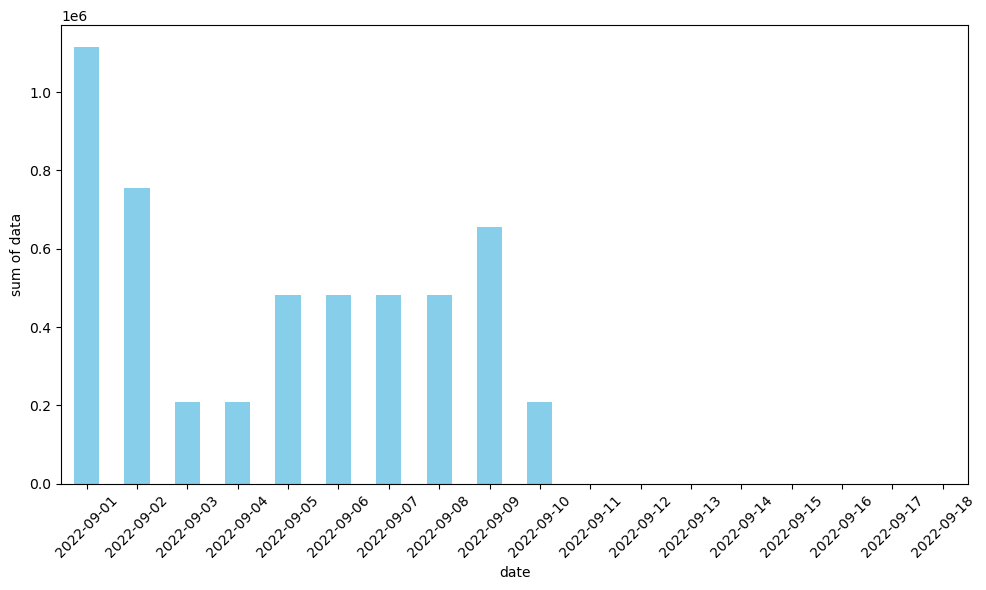

In [6]:
# Xem xét phân bố dữ liệu theo ngày tháng.
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

df['Date'] = df['Timestamp'].dt.date
df.set_index('Date', inplace=True)

daily_data_count = df.groupby(df.index).size()

plt.figure(figsize=(10, 6))
daily_data_count.plot(kind='bar', color='skyblue')
plt.xlabel('date')
plt.ylabel('sum of data')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

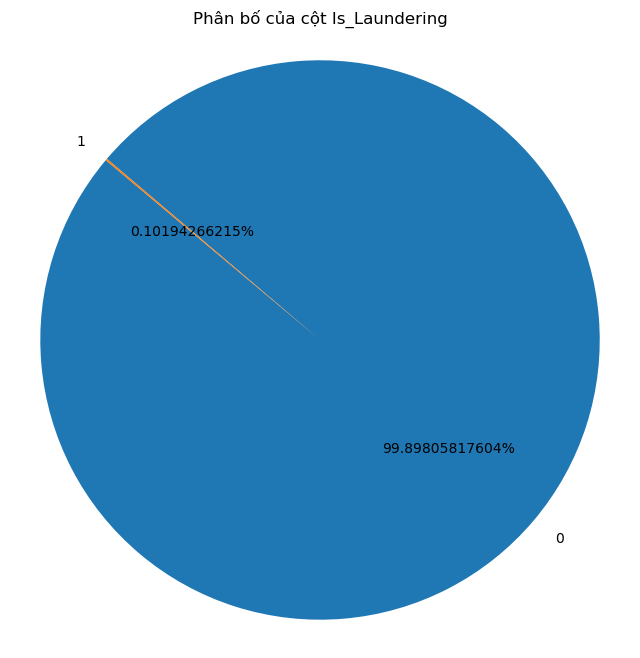

In [7]:
# Thống kê phân bố của cột “Is_Laundering”
laundering_counts = df['Is_Laundering'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(laundering_counts, labels=laundering_counts.index, autopct='%1.11f%%', startangle=140)
plt.title('Phân bố của cột Is_Laundering')
plt.axis('equal') 

plt.show()

Có thể thấy rằng phân bố của các nhãn là không cân bằng.

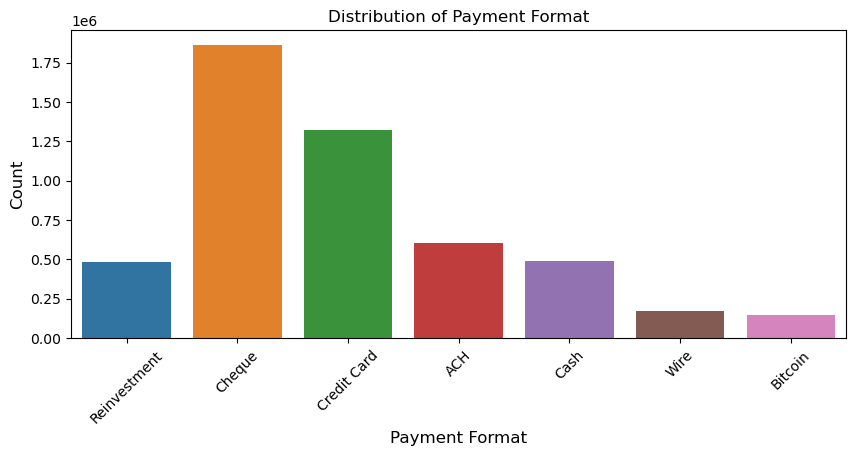

In [8]:
# Thống kê phân bố của cột “Payment Format”
f, ax = plt.subplots(figsize=(10,4))

sns.countplot(x='Payment Format', data=df, ax=ax)
ax.set_title('Distribution of Payment Format')
ax.set_xlabel('Payment Format', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.tick_params(axis='x', labelrotation=45) # rotate x-axis labels

# Set the x-axis tick labels to the original values
# ax.set_xticklabels(df['Payment Format'].unique())

plt.show()

In [9]:
df['Payment Format'].unique()

array(['Reinvestment', 'Cheque', 'Credit Card', 'ACH', 'Cash', 'Wire',
       'Bitcoin'], dtype=object)

Độ phức tạp của các phương thức thanh toán từ thấp đến cao như sau:

1.	Tiền mặt (Cash)
Tiền mặt không cần hệ thống hoặc thiết bị, hoàn tất giao dịch trực tiếp, là phương thức đơn giản nhất.

2.	Séc (Cheque)
Séc chỉ yêu cầu séc giấy và tài khoản ngân hàng, tuy đơn giản nhưng cần thời gian để hoàn tất việc đối chiếu.

3.	Hệ thống chuyển khoản tự động (ACH)
ACH yêu cầu thiết lập hệ thống chuyển tiền giữa các ngân hàng, tuy quy trình ban đầu phức tạp nhưng dễ sử dụng trong thực tế.

4.	Thẻ tín dụng (Credit Card)
Thẻ tín dụng trông có vẻ đơn giản, nhưng cần xử lý qua các tổ chức phát hành thẻ và hệ thống thanh toán phức tạp.

5.	Chuyển khoản ngân hàng (Wire)
Chuyển khoản ngân hàng dường như là việc chuyển tiền trực tiếp, nhưng liên quan đến các quy định quốc tế phức tạp và quy trình đối chiếu.

6.	Bitcoin
Bitcoin có khái niệm trừu tượng, đòi hỏi xử lý khóa bí mật, giao dịch và nhiều khái niệm mới khác.

7.	Tái đầu tư (Reinvestment)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5078345 entries, 2022-09-01 to 2022-09-10
Data columns (total 11 columns):
 #   Column              Dtype         
---  ------              -----         
 0   Timestamp           datetime64[ns]
 1   From Bank           int64         
 2   Account             object        
 3   To Bank             int64         
 4   Account.1           object        
 5   Amount Received     float64       
 6   Receiving Currency  object        
 7   Amount Paid         float64       
 8   Payment Currency    object        
 9   Payment Format      object        
 10  Is_Laundering       int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(5)
memory usage: 497.2+ MB


Có thể thấy một số thuộc tính có kiểu dữ liệu là object, vì vậy cần chuyển đổi chúng thành dạng số hóa.

In [11]:
# Xóa dữ liệu trùng lặp
print(df.shape)
df = df.drop_duplicates(keep = 'first')
df.shape

(5078345, 11)


(5078336, 11)

In [12]:
# Kiểm tra dữ liệu có giá trị NA hay không
has_nan = df.isnull().values.any()

if has_nan:
    print("NaN")
    print(df.isnull().sum())
else:
    print("not NaN")

not NaN


In [13]:
# Thông tin cơ bản của dữ liệu
df.describe()

,From Bank,To Bank,Amount Received,Amount Paid,Is_Laundering
count,5.078336e+06,5.078336e+06,5.078336e+06,5.078336e+06,5.078336e+06
mean,4.573058e+04,6.574461e+04,5.988737e+06,4.509281e+06,1.019428e-03
std,8.176567e+04,8.409303e+04,1.037184e+09,8.697736e+08,3.191221e-02
min,1.000000e+00,1.000000e+00,1.000000e-06,1.000000e-06,0.000000e+00
25%,1.190000e+02,4.259000e+03,1.833700e+02,1.844800e+02,0.000000e+00
50%,9.679000e+03,2.156800e+04,1.411040e+03,1.414570e+03,0.000000e+00
75%,2.862800e+04,1.223320e+05,1.234630e+04,1.229815e+04,0.000000e+00
max,3.563030e+05,3.562940e+05,1.046302e+12,1.046302e+12,1.000000e+00


In [14]:
# Chọn các cột có kiểu dữ liệu là object
object_cols = df.select_dtypes(include=['object']).columns.tolist()
object_cols

['Account',
 'Account.1',
 'Receiving Currency',
 'Payment Currency',
 'Payment Format']

# Tiền xử lý dữ liệu

## Chuyển đổi dữ liệu không phải kiểu số nguyên và số thực thành dạng số:

In [15]:
df.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is_Laundering
Date,,,,,,,,,,,
2022-09-01,2022-09-01 00:20:00,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0
2022-09-01,2022-09-01 00:20:00,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0
2022-09-01,2022-09-01 00:00:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0
2022-09-01,2022-09-01 00:02:00,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0
2022-09-01,2022-09-01 00:06:00,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0


In [16]:
# Xem số lượng các giá trị khác nhau trong từng thuộc tính
for col in object_cols:
    print(col,'\n')
    print(df[col].nunique(), '\n')
    print(df[col].value_counts())

Account 

496995 

100428660    168672
1004286A8    103018
100428978     20497
1004286F0     18663
100428780     17264
              ...  
806198930         1
806197550         1
80127BE50         1
8061935F0         1
8148A8671         1
Name: Account, Length: 496995, dtype: int64
Account.1 

420636 

100428660    1084
1004286A8     653
80F47A310     159
100428978     150
8018859B0     144
             ... 
80B14E9D0       1
80B159D00       1
812577710       1
812569750       1
80F91C540       1
Name: Account.1, Length: 420636, dtype: int64
Receiving Currency 

15 

US Dollar            1879341
Euro                 1172017
Swiss Franc           237884
Yuan                  206551
Shekel                194988
Rupee                 192065
UK Pound              181255
Ruble                 157361
Yen                   156319
Bitcoin               148142
Canadian Dollar       141357
Australian Dollar     138511
Mexican Peso          111030
Saudi Riyal            89971
Brazil Real         

In [17]:
# Chọn các cột có kiểu dữ liệu là object
object_cols = df.select_dtypes(include=['object']).columns.tolist()
print(object_cols)

# Sử dụng Label Encoding để chuyển đổi các cột có kiểu dữ liệu object thành dạng số
label_encoder = LabelEncoder()
for col in object_cols:
    if col != 'Payment Format':
        df[col] = label_encoder.fit_transform(df[col])

# Sắp xếp theo độ phức tạp của phương thức thanh toán
payment_map = {'Cash': 1, 'Cheque': 2, 'ACH': 3, 'Credit Card': 4, 'Wire': 5, 'Bitcoin': 6, 'Reinvestment': 7}

# Sử dụng phương pháp map để mã hóa cột Payment Format
df['Payment Format'] = df['Payment Format'].map(payment_map)

# Xem dữ liệu đã được xử lý
df.head()

['Account', 'Account.1', 'Receiving Currency', 'Payment Currency', 'Payment Format']


,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is_Laundering
Date,,,,,,,,,,,
2022-09-01,2022-09-01 00:20:00,10,942,10,900,3697.34,12,3697.34,12,7,0
2022-09-01,2022-09-01 00:20:00,3208,990,1,949,0.01,12,0.01,12,2,0
2022-09-01,2022-09-01 00:00:00,3209,991,3209,940,14675.57,12,14675.57,12,7,0
2022-09-01,2022-09-01 00:02:00,12,997,12,945,2806.97,12,2806.97,12,7,0
2022-09-01,2022-09-01 00:06:00,10,999,10,947,36682.97,12,36682.97,12,7,0


## Chuẩn hóa dữ liệu:

In [18]:
# Chuẩn hóa tất cả các thuộc tính

# Tách nhãn ra khỏi bộ dữ liệu
labels = df['Is_Laundering']
df = df.drop('Is_Laundering', axis=1)

# Chuyển cột Timestamp thành dạng timestamp
'''
    Đoạn mã này chuyển đổi cột Timestamp trong DataFrame df thành timestamp Unix.

    Cụ thể, nó chuyển đổi giá trị ngày giờ trong cột Timestamp thành timestamp Unix, 
    sau đó chia cho 10 mũ 9 để chuyển dấu thời gian thành số giây.

    Cụ thể hơn, pd.to_datetime(df['Timestamp']) chuyển đổi giá trị ngày giờ trong cột Timestamp
    thành đối tượng Timestamp của Pandas. Sau đó, .astype(int) chuyển đối tượng Timestamp thành số nguyên, 
    đại diện cho số nanô giây kể từ ngày 1 tháng 1 năm 1970. Cuối cùng, / 10**9 chia số nanô giây 
    cho 10 mũ 9 để chuyển dấu thời gian thành giây.
'''
df['Timestamp'] = pd.to_datetime(df['Timestamp']).astype(int) / 10**9

# Chuẩn hóa bộ dữ liệu
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(df)
df_normalized = scaler.transform(df)

# Chuyển dữ liệu đã được chuẩn hóa thành DataFrame và thiết lập tên cột
df_normalized = pd.DataFrame(df_normalized, columns=df.columns)

# Thêm cột nhãn trở lại bộ dữ liệu đã được chuẩn hóa
df_normalized['Is_Laundering'] = labels.tolist()

# Xem dữ liệu đã được chuẩn hóa
print(df_normalized.head())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.


   Timestamp  From Bank   Account   To Bank  Account.1  Amount Received  \
0  -0.998429  -0.999949 -0.996209 -0.999949  -0.995721             -1.0   
1  -0.998429  -0.981998 -0.996016 -1.000000  -0.995488             -1.0   
2  -1.000000  -0.981993 -0.996012 -0.981992  -0.995531             -1.0   
3  -0.999843  -0.999938 -0.995988 -0.999938  -0.995507             -1.0   
4  -0.999529  -0.999949 -0.995980 -0.999949  -0.995497             -1.0   

   Receiving Currency  Amount Paid  Payment Currency  Payment Format  \
0            0.714286         -1.0          0.714286        1.000000   
1            0.714286         -1.0          0.714286       -0.666667   
2            0.714286         -1.0          0.714286        1.000000   
3            0.714286         -1.0          0.714286        1.000000   
4            0.714286         -1.0          0.714286        1.000000   

   Is_Laundering  
0              0  
1              0  
2              0  
3              0  
4              0  


In [19]:
# Chọn các hàng có giá trị là 1 của cột Is_Laundering 
df_laundering = df_normalized.loc[df_normalized['Is_Laundering'] == 1]

# Xem dữ liệu đã được chọn
print(df_normalized.count())
df_laundering.count()

Timestamp             5078336
From Bank             5078336
Account               5078336
To Bank               5078336
Account.1             5078336
Amount Received       5078336
Receiving Currency    5078336
Amount Paid           5078336
Payment Currency      5078336
Payment Format        5078336
Is_Laundering         5078336
dtype: int64


Timestamp             5177
From Bank             5177
Account               5177
To Bank               5177
Account.1             5177
Amount Received       5177
Receiving Currency    5177
Amount Paid           5177
Payment Currency      5177
Payment Format        5177
Is_Laundering         5177
dtype: int64

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  


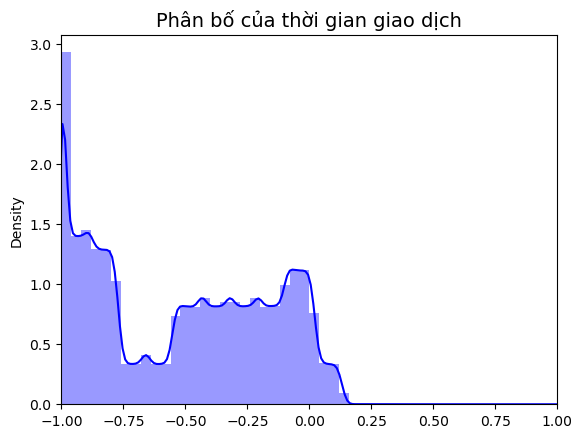

In [20]:
time_val = df_normalized['Timestamp'].values
sns.distplot(time_val, color='b')
plt.title('Phân bố của thời gian giao dịch', fontsize=14)
plt.xlim([min(time_val), max(time_val)])

plt.show()

## Tiếp theo, chia bộ dữ liệu thành tập train và tập test

In [21]:
from sklearn.model_selection import KFold, StratifiedKFold

X = df_normalized.drop('Is_Laundering', axis=1)
y = df_normalized['Is_Laundering']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

    # We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
    # original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

    # Check the Distribution of the labels


    # Turn into an array
    original_Xtrain = original_Xtrain.values
    original_Xtest = original_Xtest.values
    original_ytrain = original_ytrain.values
    original_ytest = original_ytest.values

    # See if both the train and test label distribution are similarly distributed
    train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
    test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
    print('-' * 100)

    print('Label Distributions: \n')
    print(train_counts_label/ len(original_ytrain))
    print(test_counts_label/ len(original_ytest))

Train: [1015216 1015217 1015218 ... 5078333 5078334 5078335] Test: [      0       1       2 ... 1640857 1643788 1644721]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99898072 0.00101928]
[0.99897998 0.00102002]
Train: [      0       1       2 ... 5078333 5078334 5078335] Test: [1015216 1015217 1015218 ... 2284009 2284931 2285027]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99898047 0.00101953]
[0.99898097 0.00101903]
Train: [      0       1       2 ... 5078333 5078334 5078335] Test: [2030816 2030817 2030818 ... 3208454 3208819 3214577]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99898047 0.00101953]
[0.99898097 0.00101903]
Train: [      0       1       2 ... 5078333 5078334 5078335] Test: [3046760 3046761 3046762 ... 4296460 4297262 4298091]


Có thể thấy rằng dữ liệu đã được chia thành tập train và tập test, và phân bố là cân bằng

## Sử dụng phương pháp Undersampling để chuẩn bị dữ liệu:

In [22]:
# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

# Lets shuffle the data before creating the subsamples

df_normalized = df_normalized.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = df_normalized.loc[df_normalized['Is_Laundering'] == 1]
non_fraud_df = df_normalized.loc[df_normalized['Is_Laundering'] == 0][:len(fraud_df)]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is_Laundering
2152320,-0.625972,-0.998771,0.574405,-0.998771,0.592768,-1.0,0.285714,-1.0,0.285714,-0.333333,0
791000,-0.932673,-0.943318,-0.590675,0.180265,-0.571914,-1.0,0.857143,-1.0,0.857143,-0.666667,0
4836040,0.011156,-0.957637,-0.607862,-0.917731,-0.617935,-1.0,-0.428571,-1.0,-0.428571,-0.333333,1
2016689,-0.356116,-0.937660,-0.833869,-0.372634,-0.230444,-1.0,0.714286,-1.0,0.714286,-0.333333,1
4925472,0.315814,0.353459,0.493278,-0.998821,-0.003849,-1.0,-1.000000,-1.0,-1.000000,-0.333333,1


Distribution of the Is_Launderinges in the subsample dataset
0    0.5
1    0.5
Name: Is_Laundering, dtype: float64


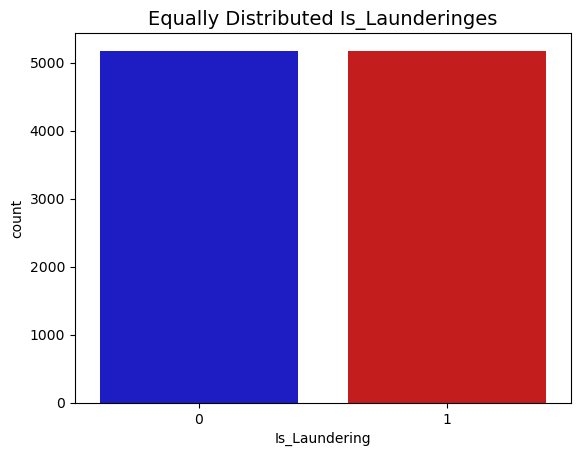

In [23]:
print('Distribution of the Is_Launderinges in the subsample dataset')
print(new_df['Is_Laundering'].value_counts()/len(new_df))

colors = ["#0101DF", "#DF0101"]
sns.countplot(data=new_df, x='Is_Laundering', palette=colors)
plt.title('Equally Distributed Is_Launderinges', fontsize=14)
plt.show()

Phương pháp undersampling: Loại bỏ toàn bộ dữ liệu có nhãn là 0 thừa, chỉ giữ lại số lượng dữ liệu có nhãn là 1 bằng với số lượng của nhãn 0

## Hệ số tương quan:

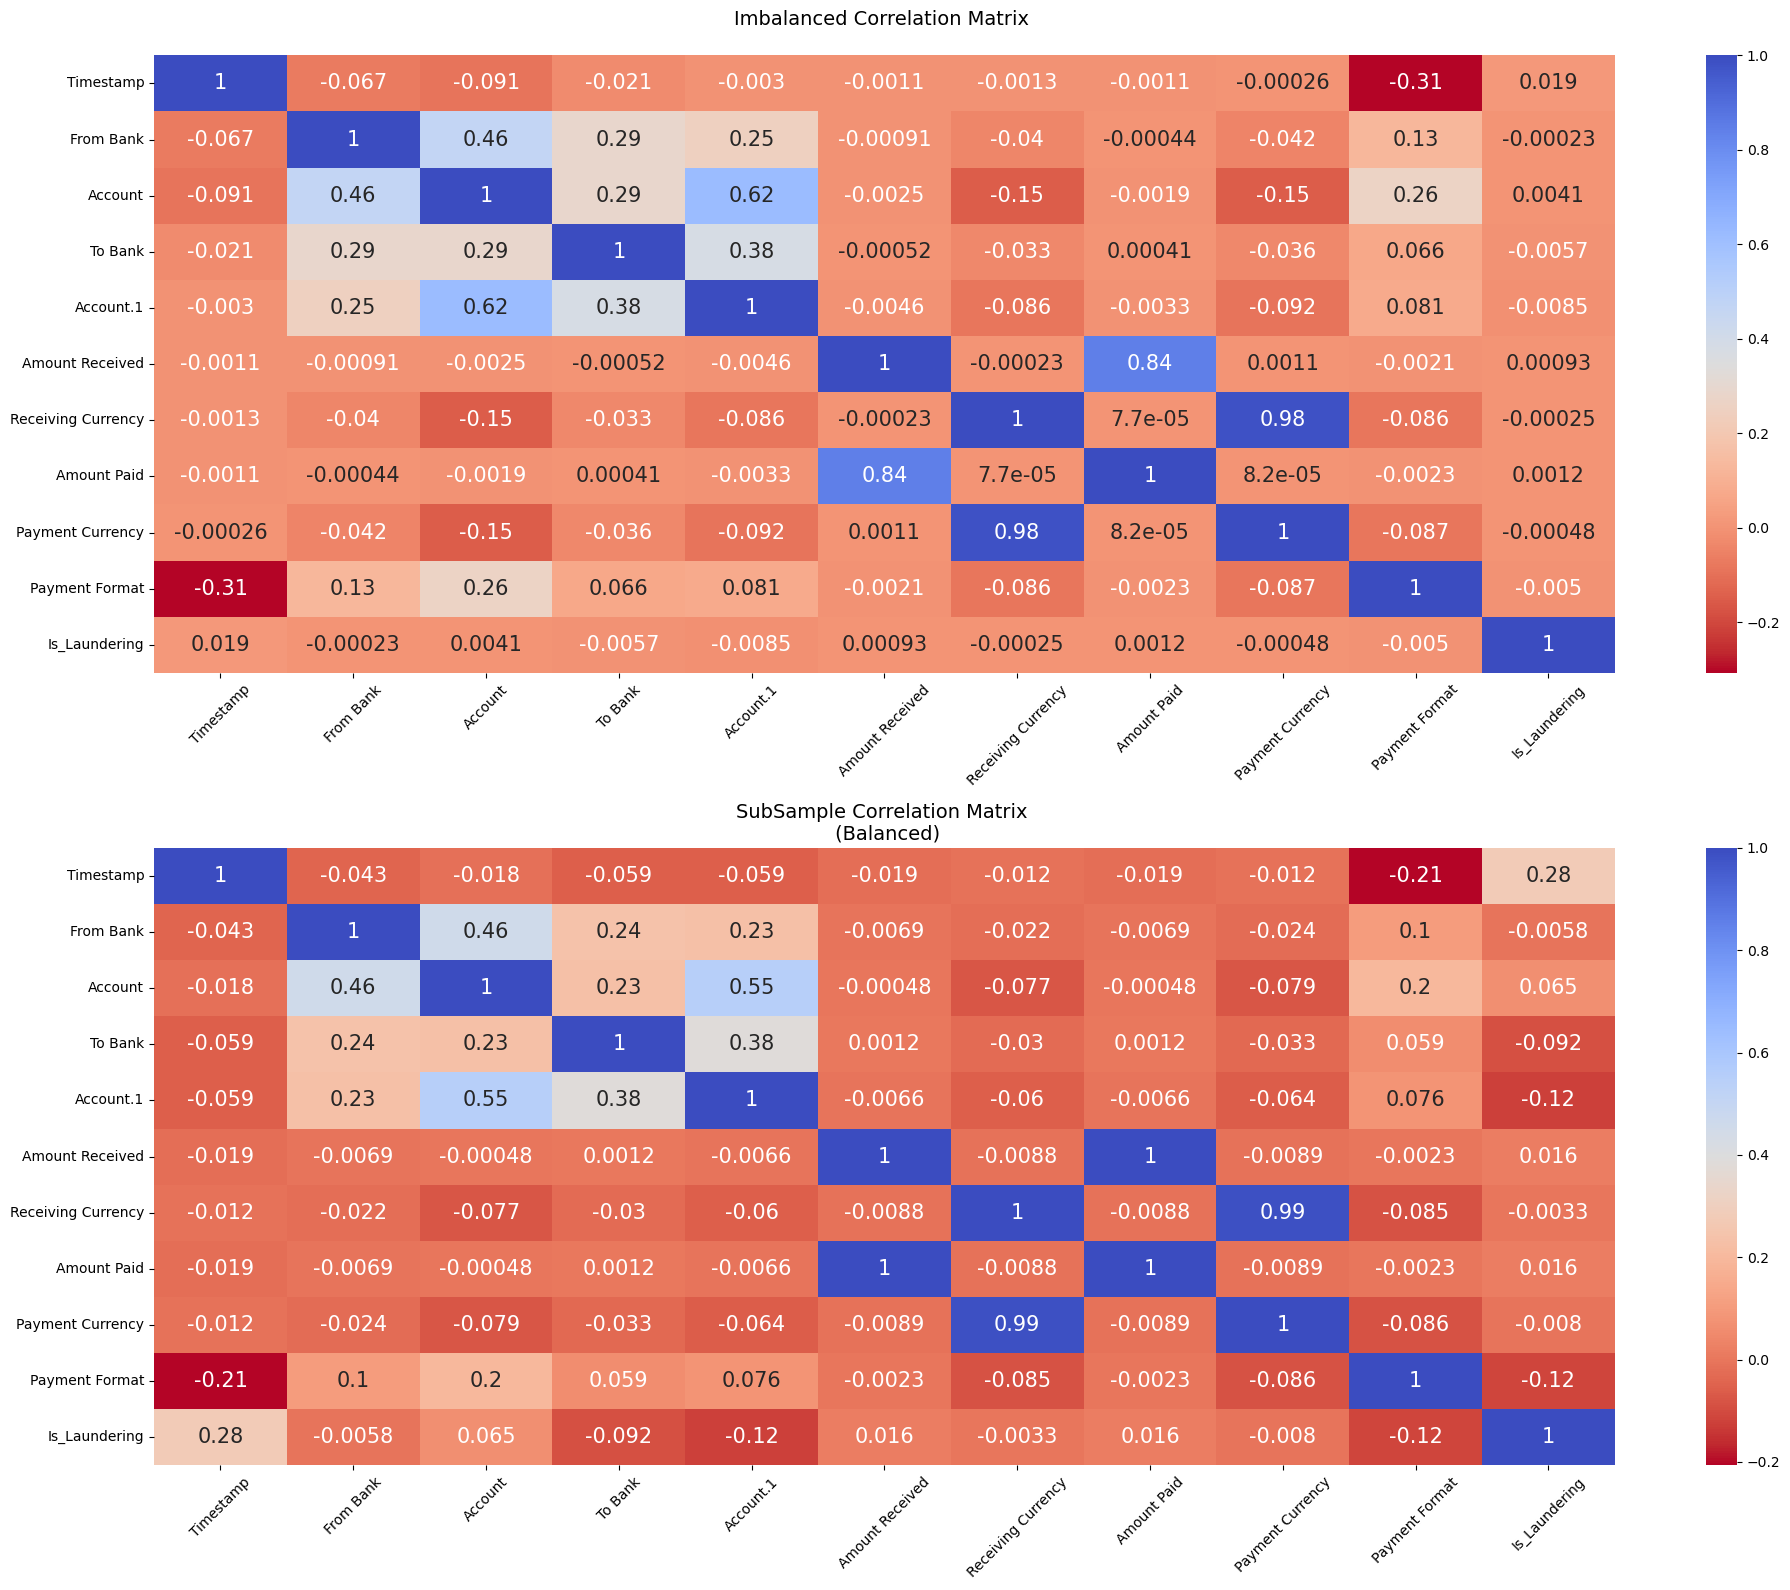

In [24]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,16))

# Toàn bộ dữ liệu
corr = df_normalized.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot=True, annot_kws={'size':15}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n ", fontsize=14)
ax1.tick_params(axis='x', labelrotation=45) # rotate x-axis labels

# Bộ dữ liệu sau khi undersampling
sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot=True, annot_kws={'size':15}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (Balanced)', fontsize=14)
ax2.tick_params(axis='x', labelrotation=45) # rotate x-axis labels
plt.tight_layout()
plt.show()


Khi sử dụng df_normalized.head(), chúng ta nhận thấy:
- Timestamp có mối tương quan dương với nhãn, nghĩa là giá trị càng lớn thì khả năng xuất hiện hành vi rửa tiền (Laundering) càng cao.
- Payment Format có mối tương quan âm với nhãn, nghĩa là giá trị càng nhỏ thì khả năng xuất hiện hành vi rửa tiền (Laundering) càng cao.

## Sử dụng biểu đồ hộp (boxplot) để quan sát sự phân bố của hai thuộc tính trên

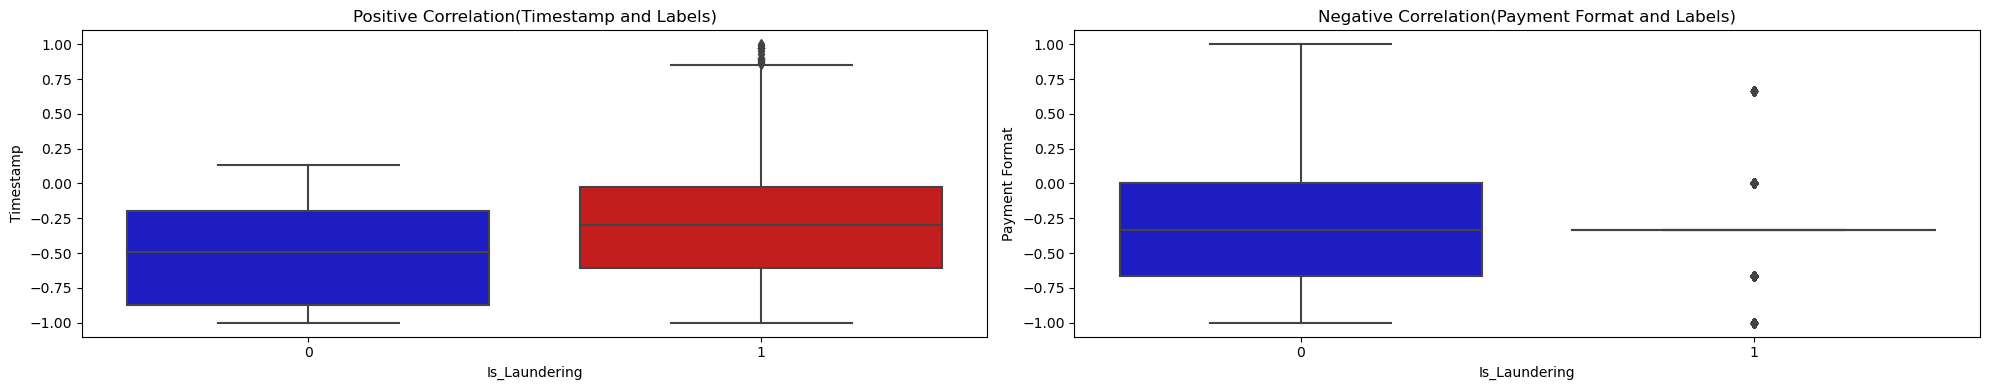

In [25]:
f, axes = plt.subplots(ncols=2, figsize=(20,4))

sns.boxplot(x="Is_Laundering", y="Timestamp", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('Positive Correlation(Timestamp and Labels)')

sns.boxplot(x="Is_Laundering", y="Payment Format", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('Negative Correlation(Payment Format and Labels)')

plt.tight_layout()
plt.show()

In [ ]:
fig1 = px.scatter(new_df, x="Timestamp", y="Is_Laundering")
fig2 = px.scatter(new_df, x="Payment Format", y="Is_Laundering")
fig1.show()
fig2.show()

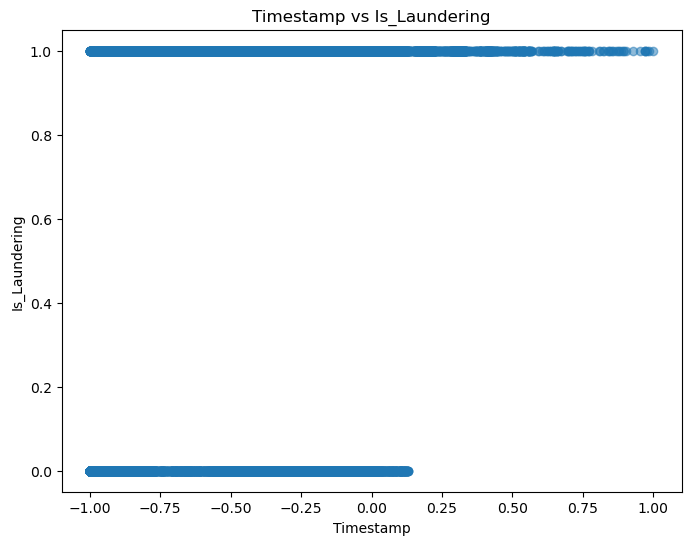

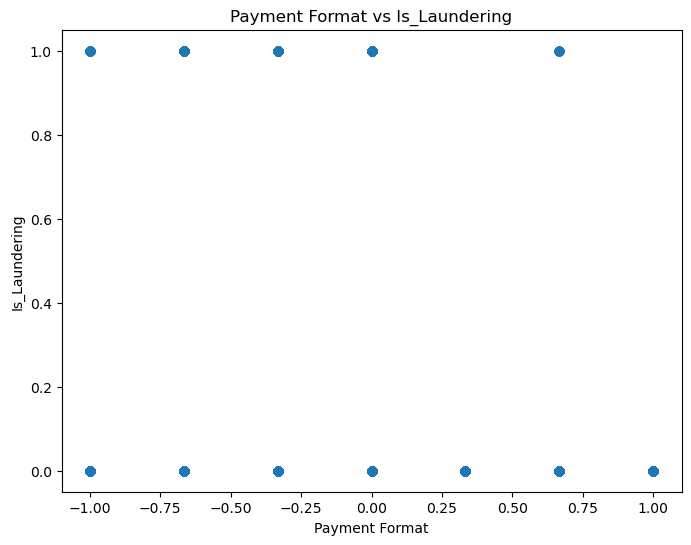

In [32]:
import matplotlib.pyplot as plt

# Scatter plot for Timestamp vs Is_Laundering
plt.figure(figsize=(8, 6))
plt.scatter(new_df['Timestamp'], new_df['Is_Laundering'], alpha=0.5)
plt.title('Timestamp vs Is_Laundering')
plt.xlabel('Timestamp')
plt.ylabel('Is_Laundering')
plt.show()

# Scatter plot for Payment Format vs Is_Laundering
plt.figure(figsize=(8, 6))
plt.scatter(new_df['Payment Format'], new_df['Is_Laundering'], alpha=0.5)
plt.title('Payment Format vs Is_Laundering')
plt.xlabel('Payment Format')
plt.ylabel('Is_Laundering')
plt.show()

Trong biểu đồ hộp đầu tiên, chúng ta có thể thấy rằng giá trị trung vị và các phần tư của cột Timestamp có mối quan hệ tương quan dương với giá trị của cột Is_Laundering. Điều này có nghĩa là, khi giá trị của cột Is_Laundering là 1, giá trị của cột Timestamp thường lớn hơn. Điều này có thể là do các giao dịch rửa tiền thường liên quan đến dòng tiền lớn, do đó cần nhiều thời gian hơn để hoàn thành.


Trong biểu đồ hộp thứ hai, chúng ta có thể thấy rằng giá trị trung vị và các phần tư của cột Payment Format không có mối quan hệ rõ ràng với giá trị của cột Is_Laundering, vì vậy việc có phải là rửa tiền hay không không liên quan trực tiếp đến phương thức giao dịch.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




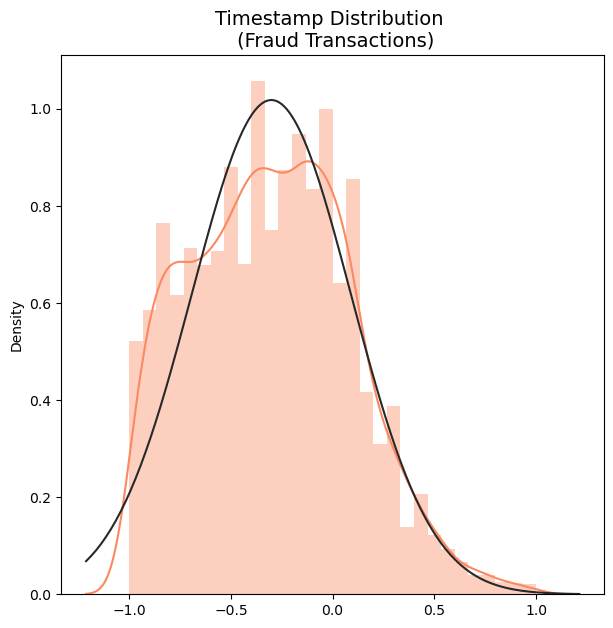

In [33]:
from scipy.stats import norm

f, ax = plt.subplots(figsize=(7, 7))

Timestamp_fraud_dist = new_df['Timestamp'].loc[new_df['Is_Laundering'] == 1].values
sns.distplot(Timestamp_fraud_dist,ax=ax, fit=norm, color='#FB8861')
ax.set_title('Timestamp Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

Có thể thấy rằng giá trị của thuộc tính timestamp khá gần với phân phối chuẩn.

## Loại bỏ giá trị outlier trong cột timestamp: 

In [34]:
Timestamp_fraud = new_df['Timestamp'].loc[new_df['Is_Laundering'] == 1].values
q25, q75 = np.percentile(Timestamp_fraud, 25), np.percentile(Timestamp_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
Timestamp_iqr = q75 - q25
print('iqr: {}'.format(Timestamp_iqr))

Timestamp_cut_off = Timestamp_iqr * 1.5
Timestamp_lower, Timestamp_upper = q25 - Timestamp_cut_off, q75 + Timestamp_cut_off
print('Cut Off: {}'.format(Timestamp_cut_off))
print('Timestamp Lower: {}'.format(Timestamp_lower))
print('Timestamp Upper: {}'.format(Timestamp_upper))

outliers = [x for x in Timestamp_fraud if x < Timestamp_lower or x > Timestamp_upper]
print('Feature Timestamp Outliers for Fraud Cases: {}'.format(len(outliers)))
print('Timestamp outliers:{}'.format(outliers))

new_df = new_df.drop(new_df[(new_df['Timestamp'] > Timestamp_upper) | (new_df['Timestamp'] < Timestamp_lower)].index)

new_df.head()

Quartile 25: -0.608767381569578 | Quartile 75: -0.023411108492382482
iqr: 0.5853562730771955
Cut Off: 0.8780344096157933
Timestamp Lower: -1.4868017911853713
Timestamp Upper: 0.8546233011234108
Feature Timestamp Outliers for Fraud Cases: 16
Timestamp outliers:[0.9699112263338066, 0.9699112263338066, 0.9764317699741696, 0.9292953099225087, 0.9704611517008743, 1.0, 0.8729672401605058, 0.8765024746644485, 0.8956713017519178, 0.9842878466497496, 0.8860083274416866, 0.8919789457145271, 0.9530992222485111, 0.8669180611204865, 0.8555267499414185, 0.9027417707598033]


,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is_Laundering
2152320,-0.625972,-0.998771,0.574405,-0.998771,0.592768,-1.0,0.285714,-1.0,0.285714,-0.333333,0
791000,-0.932673,-0.943318,-0.590675,0.180265,-0.571914,-1.0,0.857143,-1.0,0.857143,-0.666667,0
4836040,0.011156,-0.957637,-0.607862,-0.917731,-0.617935,-1.0,-0.428571,-1.0,-0.428571,-0.333333,1
2016689,-0.356116,-0.937660,-0.833869,-0.372634,-0.230444,-1.0,0.714286,-1.0,0.714286,-0.333333,1
4925472,0.315814,0.353459,0.493278,-0.998821,-0.003849,-1.0,-1.000000,-1.0,-1.000000,-0.333333,1


Text(0.5, 0.25, 'Fewer extreme \n outliers')

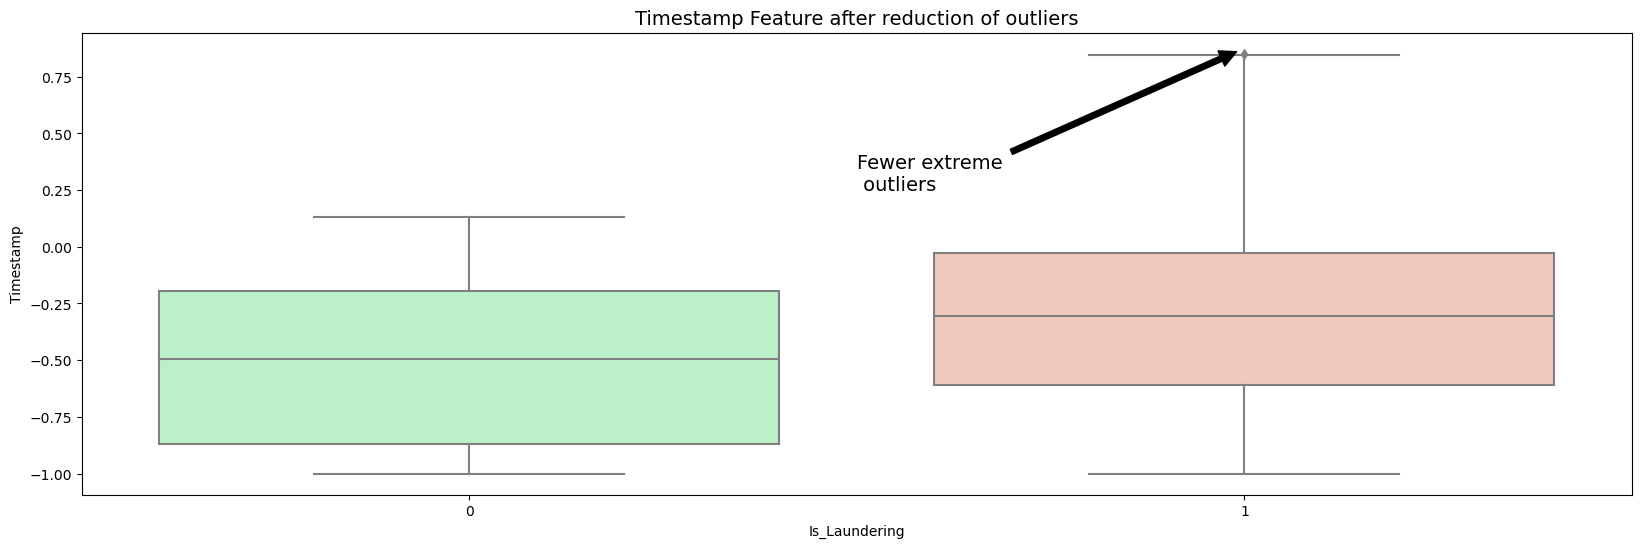

In [35]:
f,ax1 = plt.subplots(figsize=(20,6))

colors = ['#B3F9C5', '#f9c5b3']
# Boxplots with outliers removed
# Feature V14
sns.boxplot(x="Is_Laundering", y="Timestamp", data=new_df,ax=ax1, palette=colors)
ax1.set_title("Timestamp Feature after reduction of outliers", fontsize=14)
ax1.annotate('Fewer extreme \n outliers', xy=(0.99, 0.86), xytext=(0.5, 0.25),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

Có thể thấy rằng, khi nhãn là 1, các giá trị outlier trong cột timestamp đã giảm đi

## Huấn luyện mô hình:

1. Chỉ sử dụng bộ dữ liệu sau khi undersampling để huấn luyện, tức là new_df

	1.	Sử dụng trực tiếp bộ dữ liệu new_df để huấn luyện

In [36]:
# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

def run(data):
    # Undersampling before cross validating (prone to overfit)
    X = data.drop('Is_Laundering', axis=1)
    y = data['Is_Laundering']

    # Our data is already scaled we should split our training and test sets
    from sklearn.model_selection import train_test_split

    # This is explicitly used for undersampling.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Turn the values into an array for feeding the classification algorithms.
    X_train = X_train.values
    X_test = X_test.values
    y_train = y_train.values
    y_test = y_test.values

    # Let's implement simple classifiers
    classifiers = {
        "LogisiticRegression": LogisticRegression(),
        "KNearest": KNeighborsClassifier(),
        "Support Vector Classifier": SVC(),
        "DecisionTreeClassifier": DecisionTreeClassifier()
    }

    # Wow our scores are getting even high scores even when applying cross validation.
    from sklearn.model_selection import cross_val_score

    for key, classifier in classifiers.items():
        classifier.fit(X_train, y_train)
        training_score = cross_val_score(classifier, X_train, y_train, cv=5)
        print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")
        test_score = classifier.score(X_test, y_test)
        print("Classifiers: ", classifier.__class__.__name__, "Has a test score of", round(test_score, 2) * 100, "% accuracy score\n")


	2.	Sử dụng bộ dữ liệu new_df sau khi giảm chiều để huấn luyện.

a. Sử dụng ba phương pháp khác nhau để giảm chiều của new_df:

In [37]:
import time
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

# New_df is from the random undersample data (fewer instances)
X = new_df.drop('Is_Laundering', axis=1)
y = new_df['Is_Laundering']


# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



T-SNE took 5.4e+01 s
PCA took 0.039 s
Truncated SVD took 0.02 s


b. Sử dụng t-SNE và PCA kết hợp để giảm chiều.

In [38]:
# New_df is from the random undersample data (fewer instances)
X = new_df.drop('Is_Laundering', axis=1)
y = new_df['Is_Laundering']


# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_tsne_and_pca = PCA(n_components=2, random_state=42).fit_transform(X_reduced_tsne)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



T-SNE took 5.5e+01 s
PCA took 0.018 s


## Hình dung sự phân bố của new_df sau khi giảm chiều

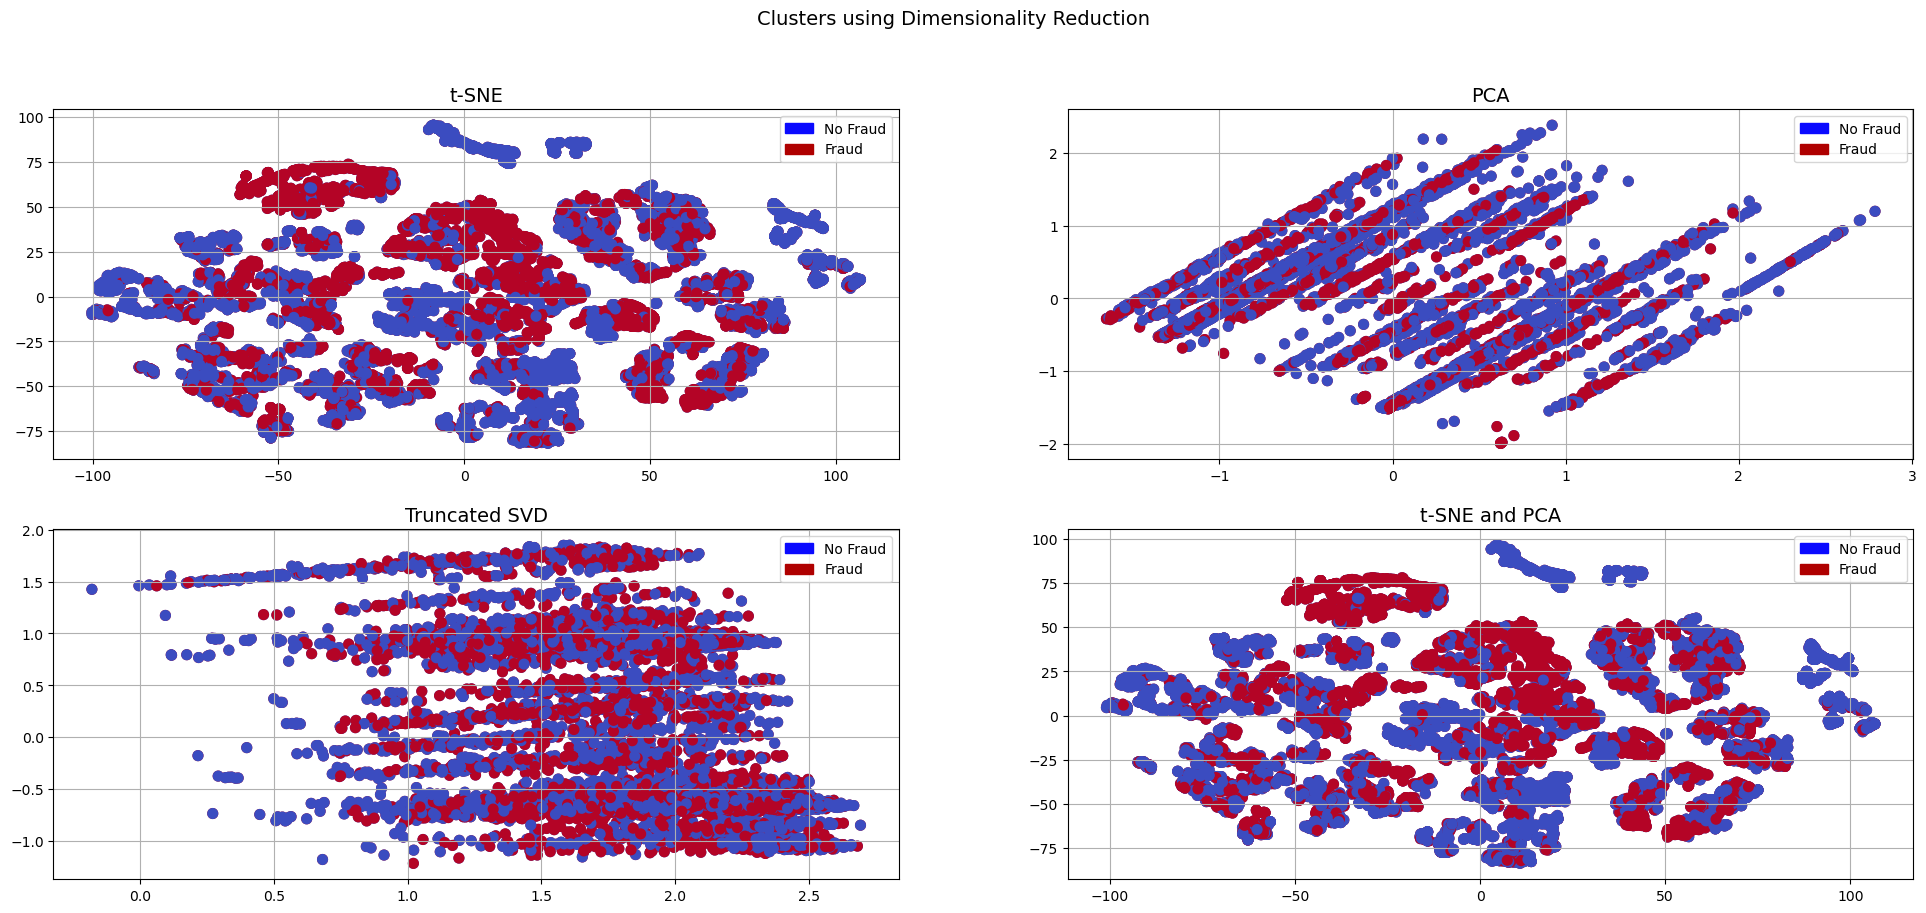

In [39]:
import matplotlib.patches as mpatches

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(24,10))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

# t-SNE and PCA
ax4.scatter(X_reduced_tsne_and_pca[:,0], X_reduced_tsne_and_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax4.scatter(X_reduced_tsne_and_pca[:,0], X_reduced_tsne_and_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax4.set_title('t-SNE and PCA', fontsize=14)

ax4.grid(True)

ax4.legend(handles=[blue_patch, red_patch])

plt.show()

Sau khi trực quan hóa dữ liệu bằng các phương pháp giảm chiều trên, có thể nhận thấy sự khác biệt giữa giao dịch gian lận và giao dịch không gian lận trong bộ dữ liệu là không rõ ràng.

## Dưới đây là quá trình huấn luyện

In [40]:
run(new_df)

Classifiers:  LogisticRegression Has a training score of 63.0 % accuracy score
Classifiers:  LogisticRegression Has a test score of 63.0 % accuracy score

Classifiers:  KNeighborsClassifier Has a training score of 83.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a test score of 82.0 % accuracy score

Classifiers:  SVC Has a training score of 82.0 % accuracy score
Classifiers:  SVC Has a test score of 83.0 % accuracy score

Classifiers:  DecisionTreeClassifier Has a training score of 86.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a test score of 84.0 % accuracy score



In [41]:
new_df.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is_Laundering
2152320,-0.625972,-0.998771,0.574405,-0.998771,0.592768,-1.0,0.285714,-1.0,0.285714,-0.333333,0
791000,-0.932673,-0.943318,-0.590675,0.180265,-0.571914,-1.0,0.857143,-1.0,0.857143,-0.666667,0
4836040,0.011156,-0.957637,-0.607862,-0.917731,-0.617935,-1.0,-0.428571,-1.0,-0.428571,-0.333333,1
2016689,-0.356116,-0.937660,-0.833869,-0.372634,-0.230444,-1.0,0.714286,-1.0,0.714286,-0.333333,1
4925472,0.315814,0.353459,0.493278,-0.998821,-0.003849,-1.0,-1.000000,-1.0,-1.000000,-0.333333,1


[0]	train-logloss:0.62301	train-error:0.07751	test-logloss:0.62919	test-error:0.12718
[1]	train-logloss:0.56526	train-error:0.07582	test-logloss:0.57729	test-error:0.12282
[2]	train-logloss:0.51578	train-error:0.07062	test-logloss:0.53354	test-error:0.11750
[3]	train-logloss:0.47460	train-error:0.07025	test-logloss:0.49758	test-error:0.11944
[4]	train-logloss:0.43736	train-error:0.06784	test-logloss:0.46670	test-error:0.12186
[5]	train-logloss:0.40576	train-error:0.06663	test-logloss:0.44016	test-error:0.12089
[6]	train-logloss:0.37714	train-error:0.06566	test-logloss:0.41685	test-error:0.12476
[7]	train-logloss:0.35150	train-error:0.06421	test-logloss:0.39663	test-error:0.12621
[8]	train-logloss:0.32951	train-error:0.06191	test-logloss:0.37976	test-error:0.12234
[9]	train-logloss:0.31035	train-error:0.06046	test-logloss:0.36507	test-error:0.12524
[10]	train-logloss:0.29246	train-error:0.05840	test-logloss:0.35304	test-error:0.12524
[11]	train-logloss:0.27722	train-error:0.05768	test-l

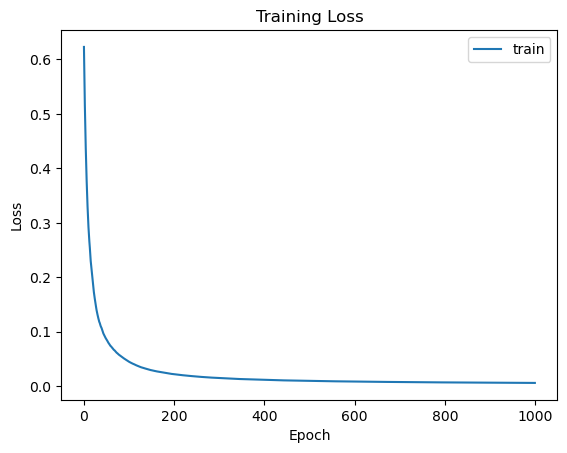

In [42]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt

# Split the dataset into features and target variable
X = new_df.drop('Is_Laundering', axis=1)
y = new_df['Is_Laundering']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define the hyperparameters for XGBoost
params = {
    'objective': 'binary:logistic',
    'eval_metric': ['logloss', 'error'],
    'eta': 0.1,
    'max_depth': 16,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'alpha': 0.1,
    'lambda': 1
}

# Train the XGBoost model and record the evaluation results
num_rounds = 1000
watchlist = [(dtrain, 'train'), (dtest, 'test')]
eval_results = {}
bst = xgb.train(params, dtrain, num_rounds, evals=watchlist, evals_result=eval_results)

# Evaluate the XGBoost model
y_pred = bst.predict(dtest)
y_pred = np.round(y_pred)
test_score = accuracy_score(y_test, y_pred)
print("XGBoost has a test score of", round(test_score, 2) * 100, "% accuracy score")

# Extract the training loss from the evaluation results
train_loss = eval_results['train']['logloss']

# Plot the training loss curve
plt.plot(train_loss, label='train')
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Vậy, XGBoost mang lại khả năng accuracy tốt nhất trên tập test đang xét, 88%, tốt hơn so với 4 phương pháp còn lại bao gồm: Logistic Regression, KNN, SVM, Decision Tree